<a href="https://colab.research.google.com/github/Varun9213/Blog_machine_learing/blob/main/Dataset_pipeline_blog_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade
!pip install pyyaml

In [2]:
from fastai import *
from fastai.vision.all import *
from fastai.imports import *
import yaml, cv2, os

In [3]:
root = Path("/content/data")

In [4]:
os.mkdir(root)
os.chdir(root)

In [ ]:
!curl -L "https://public.roboflow.com/ds/pK9BobmV9A?key=G9IUWXkCZA" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

**Data Formating Functions**

In [27]:
def get_targets(image_path):
  f = image_path.name[:-4] + ".txt"
  with open(root/"train"/"labels"/f, 'r') as file:
    targets = file.read()
  return targets.split("\n")

def get_row(image_path, target, col): 
  row = {}
  row[col[0]] = image_path.name[:-4]
  for i,t in enumerate(target.split(" ")):
    row[col[i+1]] = float(t)
  return row

def add_targets_to_df(df, image_path):
  targets = get_targets(image_path)
  df_new = df
  for target in targets:
    row = get_row(image_path, target, df.columns)
    df_new = df_new.append(row, ignore_index = True)
  return df_new

def create_df(cols, images_paths):
  df = pd.DataFrame(columns=cols)
  for path in images_paths:
    df = add_targets_to_df(df, path)
  return df

**Image Plotting Functions**

In [7]:
# def get_0_0(boxes):
#   return (boxes[:,0] - 0.5*boxes[:,2], boxes[:,1] + 0.5*boxes[:,3])

def get_0_0(boxes):
  return (boxes[0] - 0.5*boxes[2], boxes[1] + 0.5*boxes[3])

def show_img(im, figsize=None, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im,cmap=plt.cm.bone)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o,lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax,b,class_n):
    patch = ax.add_patch(patches.Rectangle(*b, fill=False, edgecolor='white', lw=1, color='r'))
    draw_outline(patch, 4)
    
def draw_text(ax,xy,txt, disp=80 ,sz=12):
    text = ax.text(xy[0],xy[1]-disp,txt,verticalalignment='top',color='white',fontsize=sz,weight='bold')
    draw_outline(text,1)

In [8]:
with open(root/"data.yaml") as file:
  data = yaml.load(file)
data

{'names': ['bishop',
  'black-bishop',
  'black-king',
  'black-knight',
  'black-pawn',
  'black-queen',
  'black-rook',
  'white-bishop',
  'white-king',
  'white-knight',
  'white-pawn',
  'white-queen',
  'white-rook'],
 'nc': 13,
 'train': '../train/images',
 'val': '../valid/images'}

In [9]:
classes = data["names"]

In [10]:
classes[10]

'white-pawn'

In [11]:
path_train = Path("/content/data/train")
path_val = Path("/content/data/valid")
path_test = Path("/content/data/test")

In [12]:
train_images = get_image_files(path_train/"images")

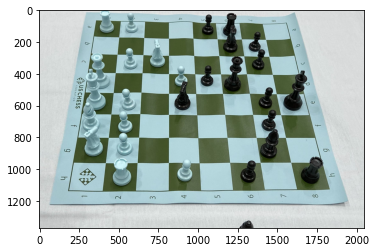

In [13]:
img = cv2.imread(str(train_images[-1]), cv2.IMREAD_UNCHANGED)
plt.imshow(img)

In [14]:
img.shape

(1371, 2048, 3)

In [17]:
f = train_images[-1].name[:-4] + ".txt"
with open(root/"train"/"labels"/f, 'r') as file:
  targets = file.read()
targets = targets.split("\n")
targets

['3 0.712890625 0.6129737609329446 0.0732421875 0.14285714285714285',
 '6 0.8388671875 0.7303206997084548 0.076171875 0.1377551020408163',
 '2 0.7880859375 0.3673469387755102 0.076171875 0.20116618075801748',
 '5 0.59765625 0.29373177842565595 0.0634765625 0.1814868804664723',
 '6 0.58740234375 0.06268221574344024 0.05078125 0.11661807580174927',
 '9 0.5888671875 0.130466472303207 0.0537109375 0.13119533527696792',
 '9 0.44091796875 0.39285714285714285 0.0615234375 0.13629737609329445',
 '4 0.51953125 0.0663265306122449 0.04638671875 0.10349854227405247',
 '4 0.67724609375 0.22813411078717202 0.048828125 0.09985422740524781',
 '4 0.66259765625 0.14431486880466474 0.046875 0.09766763848396501',
 '4 0.69873046875 0.40160349854227406 0.05078125 0.10787172011661808',
 '4 0.7060546875 0.5036443148688047 0.0546875 0.10860058309037901',
 '4 0.640625 0.7361516034985423 0.06494140625 0.11151603498542274',
 '4 0.51806640625 0.29737609329446063 0.0478515625 0.10714285714285714',
 '8 0.17236328125

In [18]:
row = [f, *targets[0].split(" ")]
row

['ec4c30d88ecc70b6a3e76dbd9b17324a_jpg.rf.34d31473728f2b9a68bb71a3f40e1d6f.txt',
 '3',
 '0.712890625',
 '0.6129737609329446',
 '0.0732421875',
 '0.14285714285714285']

In [19]:
col = ["name", "class", "center_x", "center_y", "width", "height"]
train_df = pd.DataFrame(columns= col)
train_df

,name,class,center_x,center_y,width,height


In [23]:
row = {}
row[col[0]] = f[:-4]
for i,t in enumerate(targets[0].split(" ")):
  row[col[i+1]] = float(t)
row

{'center_x': 0.712890625,
 'center_y': 0.6129737609329446,
 'class': 3.0,
 'height': 0.14285714285714285,
 'name': 'ec4c30d88ecc70b6a3e76dbd9b17324a_jpg.rf.34d31473728f2b9a68bb71a3f40e1d6f',
 'width': 0.0732421875}

In [24]:
train_df.append(row, ignore_index=True)

,name,class,center_x,center_y,width,height
0,ec4c30d88ecc70b6a3e76dbd9b17324a_jpg.rf.34d31473728f2b9a68bb71a3f40e1d6f,3.0,0.712891,0.612974,0.073242,0.142857


In [28]:
add_targets_to_df(train_df, train_images[0])

,name,class,center_x,center_y,width,height
0,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,10.0,0.276367,0.166910,0.058105,0.108601
1,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,7.0,0.443848,0.430029,0.059570,0.139213
2,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,8.0,0.166016,0.305394,0.076172,0.204810
3,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,11.0,0.347168,0.150146,0.062988,0.177843
4,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,12.0,0.436035,0.340379,0.060059,0.127551
5,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,9.0,0.451172,0.647959,0.066895,0.155248
6,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,10.0,0.258789,0.336006,0.056152,0.118076
7,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,10.0,0.354004,0.559767,0.059082,0.121720
8,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,6.0,0.270996,0.069242,0.057617,0.126093
9,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,3.0,0.244629,0.645044,0.068359,0.157434


In [29]:
final_df = create_df(col, train_images)

In [44]:
final_df.head()

,name,class,center_x,center_y,width,height
0,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,10.0,0.276367,0.166910,0.058105,0.108601
1,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,7.0,0.443848,0.430029,0.059570,0.139213
2,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,8.0,0.166016,0.305394,0.076172,0.204810
3,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,11.0,0.347168,0.150146,0.062988,0.177843
4,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,12.0,0.436035,0.340379,0.060059,0.127551


In [31]:
print(len(final_df["name"].unique()), len(train_images))

202 202


In [39]:
bboxes_cols = ["center_x","center_y","width","height"]

In [40]:
final_df[final_df["name"] == train_images[0].name[:-4]][bboxes_cols].values.shape

(14, 4)

In [34]:
final_df[final_df["name"] == train_images[0].name[:-4]]["class"]

0     10.0
1      7.0
2      8.0
3     11.0
4     12.0
5      9.0
6     10.0
7     10.0
8      6.0
9      3.0
10     2.0
11     4.0
12     4.0
13     4.0
Name: class, dtype: float64

In [35]:
def get_target_ds(name, df):

  rows = df[df["name"] == name[:-4]]
  return rows["class"].values, rows[bboxes_cols].values

In [36]:
class ChessDataset(torch.utils.data.Dataset):
  
  def __init__(self, images_path, df):
    super(ChessDataset, self).__init__()
    self.images_path = images_path
    self.df = df

  def __len__(self):
    return len(self.images_path)

  def __getitem__(self,idx):
    img_path = self.images_path[idx]
    img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    target = {}
    labels, boxes = get_target_ds(img_path.name, self.df)
    areas = boxes[:,2] * boxes[:,3]
    iscrowd = torch.zeros((boxes.shape[0],))
    image_id = torch.tensor([idx])
    target["boxes"] = boxes
    target["labels"] = labels
    target["areas"] = areas
    target["iscrowd"] = iscrowd
    target["image_id"] = image_id

    return img, target

In [37]:
dataset = ChessDataset(train_images, final_df)

In [42]:
img , target = dataset.__getitem__(1)
print(img.shape, target["boxes"], target["labels"])

(1371, 2048, 3) [[0.43994141 0.24344023 0.04638672 0.13338192]] [1.]


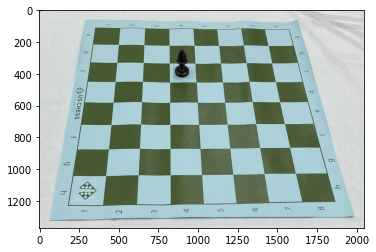

In [43]:
plt.imshow(img)